In [1]:
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch

In [2]:
image = Image.open('data/gt/SKKU_Photo9.png').convert('RGB')
image_sat = Image.open('data/sat/SKKU_Photo9.png').convert('RGB')

class Unfold(object):
    def __init__(self, crop_size, stride):
        self.crop_size = crop_size
        self.stride = stride
        
    def __call__(self, image):
        n_channels = image.shape[0]
        image = image \
            .unfold(1, self.crop_size, self.stride) \
            .unfold(2, self.crop_size, self.stride)
        image = image.permute(1,2,0,3,4)
        if n_channels == 1:
            image = image.reshape(-1, self.crop_size, self.crop_size)
        else:
            image = image.reshape(-1, n_channels, self.crop_size, self.crop_size)
        
        return image

class RotateAll(object):
    def __call__(self, image):
        images = [image]
        for i in range(1, 4):
            images.append(torch.rot90(image, i, [2, 3]))
        
        images = torch.cat(images, 0)

        return images


class AdjustColor(object):
    def __init__(self):
        self.to_pil_image = transforms.ToPILImage()
        self.tf = transforms.ColorJitter(brightness=(0.1,1.2))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image):
        transformed_image = [image]
        for i in range(4):
            transformed_image.append(self.transform(image))
        
        transformed_image = torch.cat(transformed_image, 0)
        return transformed_image

    def transform(self, image):
        transformed_image = []
        for im in image:
            im = self.to_pil_image(im)
            im = self.tf(im)
            im = self.to_tensor(im)
            transformed_image.append(im)

        transformed_image = torch.stack(transformed_image)

        return transformed_image


class Clone(object):
    def __init__(self, n):
        self.n = n
    
    def __call__(self, image):
        return torch.cat([image for _ in range(self.n)])


In [4]:
tf = transforms.Compose([
    transforms.ToTensor(),
    Unfold(crop_size=128, stride=64),
    RotateAll(),
    AdjustColor(),
    Clone(n=2)
])

tf_images = tf(image_sat)
tf_images.shape

torch.Size([9000, 3, 128, 128])

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

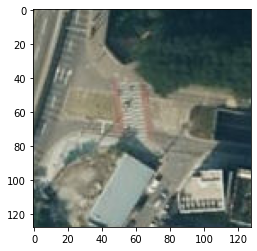

In [9]:
plt.imshow(tf_images[4500].permute(1,2,0))